# 04 Model Readiness

Purpose: assess whether `data/processed/windows.csv` is suitable for baseline model experiments.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def find_windows_csv(start: Path) -> Path:
    for p in [start.resolve()] + list(start.resolve().parents):
        candidate = p / 'data' / 'processed' / 'windows.csv'
        if candidate.exists():
            return candidate
    raise FileNotFoundError('Could not find data/processed/windows.csv')

WINDOWS_CSV = find_windows_csv(Path.cwd())
windows = pd.read_csv(WINDOWS_CSV)
print('windows.csv:', WINDOWS_CSV)
print('rows:', len(windows), 'cols:', len(windows.columns))
windows.head()


windows.csv: /Users/will/Documents/Behavioural-Biometrics-Data-Collection/Behavioural-Biometrics-Analysis/data/processed/windows.csv
rows: 21 cols: 19


,participantId,sessionId,windowIndex,has_typing,has_tapping,typing_ikt_global_mean,typing_ikt_global_std,typing_ikt_within_mean,typing_ikt_within_std,tap_rt_mean,tap_rt_std,typing_drift_ikt,tap_drift_rt,tap_miss_rate_pct,coupling_var_ikt,coupling_var_rt,coupling_var_ratio,typing_fatigue_slope,tapping_fatigue_slope
0,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,0,True,False,309.0,335.0,189.0,125.0,NaN,NaN,-1.0,NaN,0,112481.943346,NaN,NaN,17.6,-38.4
1,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,1,True,False,277.0,325.0,158.0,61.0,NaN,NaN,-57.0,NaN,0,105496.999909,NaN,NaN,17.6,-38.4
2,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,2,True,False,303.0,353.0,171.0,153.0,NaN,NaN,126.0,NaN,0,124409.280273,NaN,NaN,17.6,-38.4
3,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,3,True,True,359.0,385.0,209.0,232.0,742.0,347.0,NaN,NaN,13,147866.510191,120634.987500,0.816,17.6,-38.4
4,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,4,False,True,NaN,NaN,NaN,NaN,642.0,255.0,NaN,-177.0,8,NaN,65104.245747,NaN,17.6,-38.4


In [2]:
summary = {
    'rows': len(windows),
    'participants': windows['participantId'].nunique(dropna=True) if 'participantId' in windows.columns else 0,
    'sessions': windows['sessionId'].nunique(dropna=True) if 'sessionId' in windows.columns else 0,
}
print(summary)

if {'participantId', 'sessionId'}.issubset(windows.columns):
    counts = windows.groupby(['participantId', 'sessionId']).size().rename('n_windows').reset_index()
    display(counts.sort_values('n_windows'))


{'rows': 21, 'participants': 1, 'sessions': 3}


,participantId,sessionId,n_windows
0,pCURDWC,3be79cb28ce24d35b5b4c16cc51f8aac,7
1,pCURDWC,b30211d252ca488692fd9dec68fbf740,7
2,pCURDWC,cf7e7dad28b94d1f849c4e5e9eb7bc45,7


In [3]:
missing = windows.isna().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({'missing_frac': missing, 'missing_%': (100 * missing).round(1)})
display(missing_df)


,missing_frac,missing_%
coupling_var_ratio,0.857143,85.7
typing_drift_ikt,0.571429,57.1
tap_drift_rt,0.571429,57.1
coupling_var_rt,0.428571,42.9
coupling_var_ikt,0.428571,42.9
tap_rt_std,0.428571,42.9
typing_ikt_global_std,0.428571,42.9
tap_rt_mean,0.428571,42.9
typing_ikt_global_mean,0.428571,42.9
typing_ikt_within_std,0.428571,42.9


In [4]:
feature_cols = [
    c for c in windows.columns
    if c not in {'participantId', 'sessionId', 'windowIndex'}
]

num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(windows[c])]
print('Numeric features:', len(num_cols))
print(num_cols)


Numeric features: 16
['has_typing', 'has_tapping', 'typing_ikt_global_mean', 'typing_ikt_global_std', 'typing_ikt_within_mean', 'typing_ikt_within_std', 'tap_rt_mean', 'tap_rt_std', 'typing_drift_ikt', 'tap_drift_rt', 'tap_miss_rate_pct', 'coupling_var_ikt', 'coupling_var_rt', 'coupling_var_ratio', 'typing_fatigue_slope', 'tapping_fatigue_slope']


In [5]:
if num_cols:
    desc = windows[num_cols].describe().T
    display(desc[['mean', 'std', 'min', '50%', 'max']])


,mean,std,min,50%,max
typing_ikt_global_mean,294.333333,30.170224,248.000000,296.500000,359.000000
typing_ikt_global_std,333.583333,27.668355,278.000000,335.000000,385.000000
typing_ikt_within_mean,170.916667,17.391003,143.000000,169.500000,209.000000
typing_ikt_within_std,128.333333,45.695302,61.000000,121.500000,232.000000
tap_rt_mean,648.416667,62.135422,566.000000,636.000000,771.000000
tap_rt_std,201.000000,99.709578,90.000000,186.500000,388.000000
typing_drift_ikt,3.444444,58.489553,-57.000000,-4.000000,126.000000
tap_drift_rt,-35.666667,95.207668,-177.000000,-10.000000,61.000000
tap_miss_rate_pct,3.523810,5.644635,0.000000,0.000000,21.000000
coupling_var_ikt,111898.958619,18292.264044,77538.321330,112310.927507,147866.510191


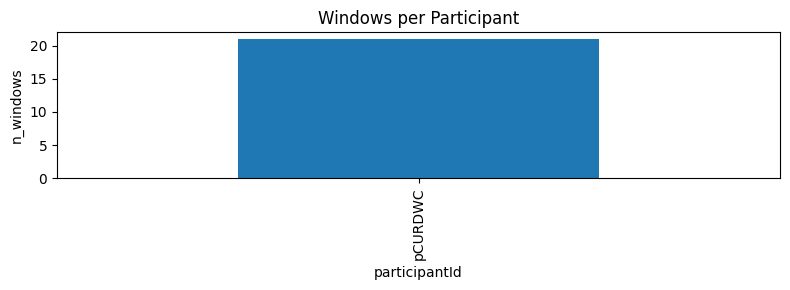

In [6]:
if {'participantId', 'sessionId'}.issubset(windows.columns):
    by_pid = windows.groupby('participantId').size().sort_values(ascending=False)
    plt.figure(figsize=(8, 3))
    by_pid.plot(kind='bar')
    plt.title('Windows per Participant')
    plt.ylabel('n_windows')
    plt.tight_layout()
    plt.show()


In [7]:
readiness_flags = []

if len(windows) < 100:
    readiness_flags.append('LOW_ROWS: fewer than 100 windows')
if 'participantId' in windows.columns and windows['participantId'].nunique(dropna=True) < 5:
    readiness_flags.append('LOW_PARTICIPANTS: fewer than 5 participants')
if missing.max() > 0.8:
    readiness_flags.append('HIGH_MISSINGNESS: at least one column >80% missing')

if readiness_flags:
    print('Model readiness: LIMITED')
    for f in readiness_flags:
        print('-', f)
else:
    print('Model readiness: GOOD for baseline experiments')


Model readiness: LIMITED
- LOW_ROWS: fewer than 100 windows
- LOW_PARTICIPANTS: fewer than 5 participants
- HIGH_MISSINGNESS: at least one column >80% missing
